# Linear Models For Classification

In linear regression models, the model prediction $y(x, w)$ was given by a linear function of the parameters w. In the simplest case, the model is also linear in the input variables and therefore takes the form $y(x) = w^T x + w_0$ , so that y is a real number. For classification problems, however, we wish to predict discrete class labels, or more generally posterior probabilities that lie in the range (0, 1). To achieve this, we consider a generalization of this model in which we transform the linear function of w using a nonlinear function $f(·)$ so that $y(x) = f(w^T x + w_0)$.

## Data

Iris data set on uci machine learning website https://archive.ics.uci.edu/ml/datasets/Iris.

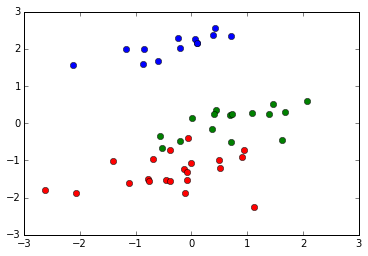

In [95]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st


#Reading and preparing the data set
D = np.loadtxt('./data/classification_iris.csv', delimiter=',')
np.random.shuffle(D); N = D.shape[0]; V = D.shape[1]-1; C = 3;
    
#split into training and test set
X_tr = D[0:100,:V]; T_tr = D[0:100,4]; N_tr = X_tr.shape[0]; 
X_te = D[100:,:V]; T_te = D[100:,4]; N_te = X_te.shape[0];


#evaluation function
acc = lambda Y, T: np.sum(np.equal(Y, T)) / T.shape[0]

#print data in two dimenssiona using pca and plot the decision boundary
def plot_cls_decision(X, Y):
    #Standarize
    mu = X.mean(axis=0); X_p = (X - mu)/X.std(axis=0);      
    #compute svd decomposition
    eigenvectors, eigenvalues, V = np.linalg.svd(X_p.T, full_matrices=False)    
    
    #project data        
    X_p = np.dot(X_p, eigenvectors[[1,2],:].T)
    
    #plot data points
    labels = np.unique(Y);
    for cl in labels:    
        ind = np.equal(Y, cl);        
        plt.plot(X_p[ind,0], X_p[ind,1],'o')
            
plot_cls_decision(X_te, T_te)

## Discriminant Functions
A discriminant is a function that takes an input vector x and assigns it to one of K classes, denoted $C_k$. we shall restrict attention to linear discriminants, namely those for which the decision surfaces are hyperplanes. It can ben seen as the combination of learning and inference in a single step.

### Least Square

Our aim is to assign dicrete labels to new samples given pattern learnt from the training dataset. We can enconde K labels as $(t_1,..,t_k) \mid t_n \in {0,1}$ where $t_k = 1$, iff it belongs to class $C_k$. So we can see this as a regression model for multiple outputs. Therefore, we can define a linear model so that $y_k(x) = w_k^T x + w_{k0}$ where $k = 1, . . . , K$. 

We can conveniently group these together using vector notation so that $Y(x) = W^T x$. Thus, this is a discriminant functions where W is a matrix whose k th column comprises the D + 1-dimensional vector $w_k = (w_{k0} , w_k^T )^T$ and x is the corresponding augmented input vector $(1, x^T)^T$ with a dummy input $x_0 = 1$. A new input x is then assigned to the class for which the output $y_k = w_k^T x$ is largest ,and we determine the parameter matrix W by minimizing a sum-of-squares error between the targets variables and the estimated values, as follows,

$$E(W) = \frac{1}{2} \sum_n (y_n - tn)^2$$
which can be written in the following matrix form,
$$E(W) = \frac{1}{2} Tr(X W − T)^T (XW − T)$$

Where X is the matrix where each row is a examples, T is the matrix where each row is the example label encoded and W are the model's parameters.



we can find a close form solution by derivating in relation to W and euqating to zero, so we have 
$$W = ( X^T X)^{−1} X^T T$$

It is important notice some points:
* Least square is not robust to outliers
* It is good because have a closed form solution for the parameters
* Least square Square corresponds to maximum likelihood under the assumption of a Gaussian conditional distribution, whereas binary target vectors clearly have a distribution that is far from Gaussian.




Training set accuracy: 0.84
Test set accuracy: 0.86


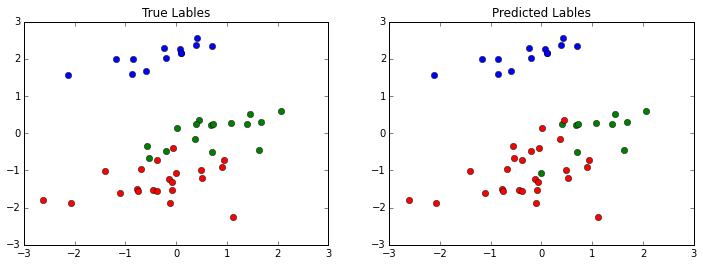

In [96]:
# Adapt dataset
X_tr_ls = np.concatenate((np.ones((N_tr,1)), X_tr), axis=1)
T_tr_ls = np.zeros((N_tr,C)); 
for idx in range(N_tr):
    T_tr_ls[idx, T_tr[idx]] = 1;
    
# learn W parameters for the discriminat function
LS_learn = lambda X, T:  np.dot(np.dot(np.linalg.pinv(np.dot(np.transpose(X),X)),np.transpose(X)),T);
W_ls = LS_learn(X_tr_ls, T_tr_ls)

#Predicte given a new iput
LS_pred = lambda x : np.argmax(np.dot(np.transpose(W_ls),np.concatenate((np.ones(1),x), axis=0)));

#evaluating
Y_tr = np.apply_along_axis(LS_pred,1,X_tr)
Y_te = np.apply_along_axis(LS_pred,1,X_te)
print('Training set accuracy: {}'.format(acc(Y_tr,T_tr)))
print('Test set accuracy: {}'.format(acc(Y_te,T_te)))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1);plot_cls_decision(X_te, T_te);plt.title('True Lables')
plt.subplot(1,2,2);plot_cls_decision(X_te, Y_te);plt.title('Predicted Lables')

### Fisher’s Discriminant

The linear model descibed before can be seen as a dimensionality reduction $y = W^t x$ from D-dimenssion to one where the inference can be done by $y > w_{0}$ in two-class case. The projection onto one dimension leads to a considerable loss of information, and classes that are well separated in the original D-dimensional space may become strongly overlapping in one dimension. However, by adjusting the components of the weight vector w, we can select a projection (direction) that maximizes the class separation and minimizes the within-class variance. Therefore, The idea proposed by Fisher is to maximize a function that will give a large separation between the projected class means while also giving a small variance within each class, thereby minimizing the class overlap. This can be achieved maximizing the following objective called The Fisher criterion:

$$J(W) = \frac{\sigma_{between}^2}{\sigma_{within}^2} = \frac{w^TS_bw}{w^TS_ww}$$

where $S_w$ is the within class variance and $S_b$ between class variance. They are defined as follow,
$$S_w = \sum_{k \in K} S_k$$
$$S_k = \sum_{n \in C_k} (x_n - m_k) (x_n-m_k)^T$$
$$ m_k = \frac{1}{N_k} \sum_{n \in C_k} X_n$$
$$S_B = \sum_{k \in K} N_k (m_k - m) (m_k - m)^T$$
$$ m = \frac{1}{N} \sum X_n$$

Maximization of such criteria is straightforward, though somewhat involved. We can say taht the weight values are determined by those K eigenvectors of $S_W^{-1} S_B$ that correspond to the K largest eigenvalues. Thus thre transformation is perfomed as $y = W^T x$, where X is D-dimensional and Y is K-dimensional




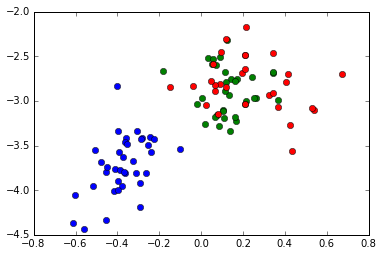

In [97]:
# build the mean vectors of each class as lines of M
M = []
for cl in range(C):    
    ind = np.equal(T_tr, cl);        
    M.append(np.mean(X_tr[ind,:], axis=0))
    
    
# Within-class scatter matrix SW
S_w = np.zeros((V,V))
for cl in range(C):
    S_i = np.zeros((V,V))    
    ind = np.equal(T_tr, cl)     
    m_i = M[cl]
    #within class matrix
    for x in X_tr[ind,:]:        
        x, m_i = x.reshape(V,1), m_i.reshape(V,1) # make column vector  
        S_i += (x-m_i).dot((x-m_i).T)
    
    S_w += S_i

# between-class scatter S_b
mean = np.mean(X_tr, axis=0)
S_b = np.zeros((V,V))
for cl, m_i in enumerate(M):
    n = X_tr[np.equal(T_tr, cl),:].shape[0]    
    
    m_i, mean = m_i.reshape(V,1), mean.reshape(V,1)  # make column vector    
    S_b += n * (m_i - mean).dot((m_i - mean).T)

# Solving the generalized eigenvalue problem for the matrix SW-1SB
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_w).dot(S_b))

# Selecting K linear discriminants for the new feature subspace
K = 2; ind = np.argsort(eig_vals)[::-1][:K];
W_lda = np.transpose(eig_vecs[ind,:]);

# transform input space
lda_trans = lambda x: np.dot(W_lda.T, x)
X_ldatr = np.apply_along_axis(lda_trans,1,X_tr)

for cl in range(C):    
    ind = np.equal(T_tr, cl);        
    plt.plot(X_ldatr[ind,0],X_ldatr[ind,1],'o')
    

Fisher discriminat alone is note a discriminat function for classification. Instead it is a liner tranformation that transforms the D dimensional input space to a K dimensional output space where there are a maximum sepration between classes and minimum within class variance. In addition, any linear classifier should work better in this new output space than in the input space. Now we can use Probabilty Theory and Information Theory to build a classifier as follow,

$$ \textrm{argmax}_{C_k} P(C_k \mid Y) = \textrm{argmax}_{C_k} P(Y \mid C_k) P(C_k) =  \textrm{argmax}_{C_k} N(\mu,\Sigma) \frac{N_{C_k}}{N}$$

Where Y is in the transformed space by $Y = W^T x$. Given a new example, our classifier assigns the class that provides the highest posteriori probability write in terms of prior and likelihood. In order to fit a gaussian to the likelihood we can use also Maximum likelihood approach or Bayesian. Note that all these probability estimation should be done in the transformed space provided by Fisher Discriminat.





Training set accuracy: 0.82
Test set accuracy: 0.68


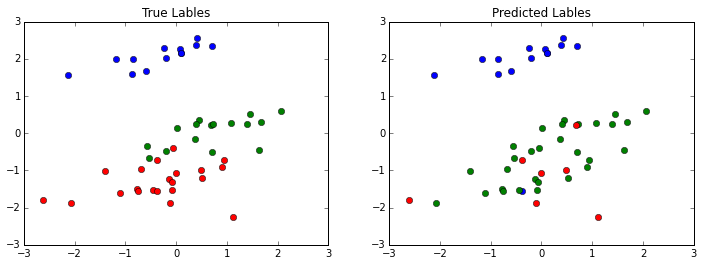

In [98]:
# define the prior P(C_k) and the evidence P(Y|C_k) pobability
P_c = np.zeros(C); P_Yc = [];
for cl in range(C):
    ind = np.equal(T_tr, cl)
    X_cl = X_ldatr[ind,:];
    
    # Prior P(C)
    P_c[cl] = X_cl.shape[0] / X_ldatr.shape[0]
    
    # evidence P(Y|C) is a gaussian 
    Yc_mu = np.mean(X_cl, axis=0); Yc_cov = np.cov(X_cl, rowvar=0);
    P_Yc.append(st.multivariate_normal(mean=Yc_mu, cov=Yc_cov));
    

# Predict the class with the highest posteriori probability given by bayes teorem
LDA_pred = lambda x : np.argmax(np.array([p.pdf(lda_trans(x)) for p in P_Yc]) * P_c)

# Make predictions 
Y_lda_pred_tr = np.apply_along_axis(LDA_pred,1,X_tr)
Y_lda_pred_te = np.apply_along_axis(LDA_pred,1,X_te)

print('Training set accuracy: {}'.format(acc(Y_lda_pred_tr,T_tr)))
print('Test set accuracy: {}'.format(acc(Y_lda_pred_te,T_te)))
plt.figure(figsize=(12,4))
plt.subplot(1,2,1);plot_cls_decision(X_te, T_te);plt.title('True Lables')
plt.subplot(1,2,2);plot_cls_decision(X_te, Y_lda_pred_te);plt.title('Predicted Lables')

## Probabilistic Generative Models

Genrative models for classification basically models the class-conditional densities $p(x|C_k)$, as well as the class priors $p(C_k)$, then use these to compute posterior probabilities $p(C_k|x)$ through Bayes’ theorem, and use the posterior probability to make classifications decisions based on Decison theory techniques. 

$$ \textrm{argmax}_{C_k} P(C_k \mid X) = \textrm{argmax}_{C_k} P(X \mid C_k) P(C_k)$$

Since our input variables are continuous valued we can model the $P(X \mid C_k)$ as gaussians that share the same covariace matrix. Doing this we can fit gaussians to each class by estimating its parameters using Maximum log-likelihood as fallow,
$$l(X,C_k;\phi,\mu,\Sigma) = \prod^K P(X|C_k;\mu_k,\Sigma)  P(C_k;\phi_k)$$
which end up,

$$\mu_k = \frac{1}{N_k}\sum_{n \in C_k}X_n$$
$$\Sigma = \sum^K \frac{1}{N} \sum_{n \in C_k} (X_n - \mu_k) (X_n - \mu_k)^T$$

However, using the softmax function and the same covariance matrix for all of the classes conditionals, we can see the posterior probability $P(C_k \mid x)$ as a linear function of parameters $ a_k(x) = w_k^T x + w_{ok}$, such as
$$P(C_k \mid X) = \frac{exp(a_k(x))}{\sum_K exp(a_k(x))}$$
where,
$$w_k = \Sigma^{-1} \mu_k$$
$$w_0k = \left(-\frac{1}{2}\right) \mu_k^T \Sigma^{-1} \mu_k + ln \phi_k$$

Therefore, in order to learn the model we need learn the parameters of class-conditional densities $p(x|C_k)$, as well as the class priors $p(C_k)$, and from these parameters we can compute our linear model parameters $w_k$ and $w_{ok}$. Finnaly to perform inference we just need to compute the function $Y = w_k^T x + w_ok$ and feed in the softmax function to obtain the posteriori distribution $P(C_k \mid x)$. Then we assign to x the label that gives the highest posterior probability.

Points to Note:
1. If we consider that each class has a different covariance matrix we end up with a quadratic boundary instead of a linear one.
2. This model is not robust since maximum likelihood is no robust estimator.
3. This model also makes strong assumption about of the data (e.g. the data is a gaussian) that huts the performance if the true distributions of the data is not what we assumed.
4. Assuming that the class-conditional densities $p(x|C_k)$ are members of the exponential family of distributions we can show that exists a generalized linear models with logistic sigmoid (K = 2 classes) or softmax (K > 2 classes) activation functions.


Training set accuracy: 0.97
Test set accuracy: 1.0


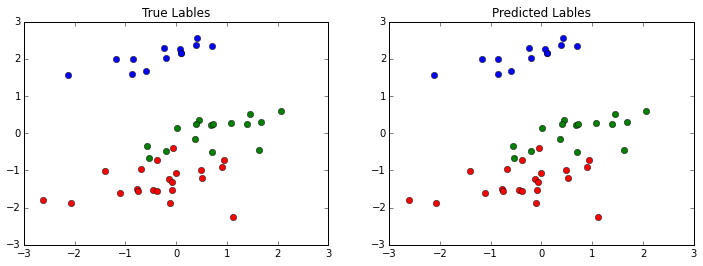

In [99]:
# compute MLE parameters of the model
mu = []; pi = []; cov = np.zeros((V,V));
for cl in range(C):
    ind = np.equal(T_tr, cl)
    
    N_c = np.sum(ind,axis=0); pi.append(N_c/N_tr);
    
    mu_cl = (1.0/N_c) * np.sum(X_tr[ind, :], axis=0)
    mu.append(mu_cl)
    
    cov += (N_c/N_tr) * np.cov(X_tr[ind, :], rowvar=0)

# compute the generalized model parameters W and w_0 from the distribution parameters
W_gm = np.zeros((V,C)); W0_gm = np.zeros((C,1)) 
for cl in range(C):
    W_gm[:,cl] = np.squeeze(np.dot(np.linalg.pinv(cov), mu[cl].reshape((V,1))))
    W0_gm[cl] = (-0.5)*np.dot(np.dot(np.transpose(mu[cl]), np.linalg.pinv(cov)), mu[cl]) + np.log(pi[cl]) 
    
    
# compute softmax  
GM_prob = lambda x: np.exp(np.dot(W_gm.T, x.reshape(V,1)) + W0_gm) / np.sum(np.exp(np.dot(W_gm.T, x.reshape(V,1)) + W0_gm)) 
GM_pred = lambda x: np.argmax(GM_prob(x))

#Evaluate
# Make predictions 
Y_gm_pred_tr = np.apply_along_axis(GM_pred,1,X_tr)
Y_gm_pred_te = np.apply_along_axis(GM_pred,1,X_te)


print('Training set accuracy: {}'.format(acc(Y_gm_pred_tr,T_tr)))
print('Test set accuracy: {}'.format(acc(Y_gm_pred_te,T_te)))
plt.figure(figsize=(12,4))
plt.subplot(1,2,1);plot_cls_decision(X_te, T_te);plt.title('True Lables')
plt.subplot(1,2,2);plot_cls_decision(X_te, Y_gm_pred_te);plt.title('Predicted Lables')

## Probabilistic Discriminative Models

### Prob. Generative Models Vs Prob. Discriminative Models
The Prob. Generative Models consists on indirectly find the parameters of a generalized linear model, by fitting class-conditional densities and class priors separately using maximum likelihood to determine the parameters of those densities and then applying Bayes’ theorem to find the posterior class probabilities that is used to predict the class label of a given sample. While,  Prob. Discriminative Models uses the functional form of the generalized linear model explicitly and to determine its parameters directly by using maximum likelihood.

One advantage of the discriminative approach is that there will typically be fewer adaptive parameters to be determined ($W~\text{and}~W_0$ = M parameters vs $\mu + \Sigma + \phi$ = $(M + M(M-1)/2 + k$). It may also lead to improved predictive performance, particularly when the class-conditional density assumptions give a poor approximation to the true distributions.



### Logistic Regression

Starting from a binary classification problem, let define the probability of sample $x$ belongs to class $C_1$ equal to
a sigmoid function on a linear combination of the model parameters w and features x, as follows,
$$P(C_1|x) = \frac{1}{1 + e^{(-(W^T x))}} = y_{n}$$ 

Then, the probability of sample $x$ belongs to class $C_2$ can be write as $P(C_2|x) = 1 - P(C_1|x)$. Therefore, we can define the following likelihood function of a data 

$$p(T \mid W) = \prod_n y_{n}^{t_{n}} (1-y_{n})^{1-t_n}$$
where $x \in R^D$ is the feature vector and $t \in (0,1)$ is the target classification. $t_n = 1$ if sample n belongs to class $C_1$, otherwise, $t_n = 0$.

We can rewrite the maximum likelihood estimation as a minimization of the negative loglikelihood (Error function). We end up with the following cross entropy error function,
$$E(W) = - ln (p(T \mid W)) = \sum_n t_{n}ln(y_n) + (1-t_n)(1-y_{nk})$$

In order to minimize this error we can compute the gradient in relation to W and use the gradient descent approach or compute the gradient and the hessian and use the Newton-Raphson (also called Iterative reweighted least squares) method. This method does not provide closed form solution but converges fast than the gradient descent. IRLS could be computationally inefficient since it is necessary to compute and invert the hesssian matrix in each iteration. The gradient and hessian are defined below in either single equation form or matrix form.

$$\nabla E(W) = \sum_n (y_n-t_n)x_n = X^T(Y-T) $$

$$H(W) =\nabla \nabla E(W) = \sum_n y_n(1-y_n)x_nx_n^T =  X^TRX$$

where $R$ is a diagonal matrix NxN with elements $R_{nn} = y_n(1-y_n)$. The IRLS update rule is
$$W^{(\tau + 1)} = W^{(\tau)} - H^{-1} \nabla E(W)$$

However, our dataset have more than one class. We can extend the logistic regression for the multiclass case and derive all the equation required, but now we are gonna use the one-vs-all algorithm to transform a multiclass problem in K binary classification problem for simplicity. The one-vs-all algorithm consist in train one logistic regression classifier for each class and assign the label that gives the highest probability for a given sample.

**Note:**
1. A regularizer such as L2-Regularization can be used to avoid overfitting provided by the MLE of parameters
2. The Newton-Ramphson method minimizes the function by the direction of the gradient modularized by the intensity given by the 2 derivative. 
3. The logistic regression also have a direct model to multiclass problems called multinomial logistic regression, that should be better in most of the cases.

Training set accuracy: 0.97
Test set accuracy: 1.0


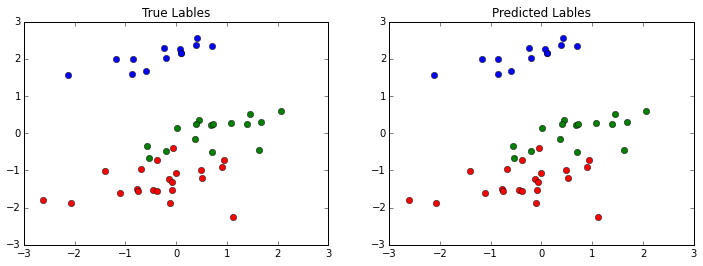

In [100]:
#parameters 
MAX_IT = 100

# Adapt dataset for basis functions (here just use phi(X) = X)
X_tr_lr = np.concatenate((np.ones((N_tr,1)), X_tr), axis=1)

# IRLS Algorithm
W_lr = np.zeros((V+1,C))
for cl in range(C):
    for it in range(MAX_IT):
        #prediction
        Y = np.dot(X_tr_lr, W_lr[:,[cl]]);Y = 1 / (1 + np.exp(-Y))        
        Tg = np.equal(T_tr, cl).reshape(N_tr,1)
        
        #compute gradient
        G = np.sum(X_tr_lr * (Y - Tg), axis = 0, keepdims=True).T;
        
        #compute hessian
        R = np.identity(N_tr) * (Y *(1-Y))
        H = np.dot(np.dot(X_tr_lr.T, R),X_tr_lr)
        
        #update weights        
        W_lr[:,[cl]] = W_lr[:,[cl]] - np.dot(np.linalg.pinv(H), G)
        
        
# Probability and Prediction  for a single given x
LR_prob = lambda x: 1 / (1 + np.exp(-np.dot(W_lr.T, np.concatenate((np.ones(1),x.T), axis=0))))
LR_pred = lambda x: np.argmax(LR_prob(x))
        
#Evaluate
Y_LR_pred_tr = np.apply_along_axis(LR_pred,1,X_tr)
Y_LR_pred_te = np.apply_along_axis(LR_pred,1,X_te)

print('Training set accuracy: {}'.format(acc(Y_LR_pred_tr,T_tr)))
print('Test set accuracy: {}'.format(acc(Y_LR_pred_te,T_te)))
plt.figure(figsize=(12,4))
plt.subplot(1,2,1);plot_cls_decision(X_te, T_te);plt.title('True Lables')
plt.subplot(1,2,2);plot_cls_decision(X_te, Y_LR_pred_te);plt.title('Predicted Lables')

### Important results

* Exponetial family results:
Assuming a conditional distribution for the target variable from the exponential family, along with a corresponding choice for the activation function known as the canonical link function, the gradient of the error function for the negative log of MLE is equal the error times the feature vector. Ex: Linear Regression, Logistic Regression.

## Bayesian Logistic Regression

Before explain the Bayesian logistic regression, we need to know how to do a laplace approximation, since Exact Bayesian inference and Evaluation of the predictive distribution for the logistic regression  is intractable, because it is necessary to normalise a product of prior probabilities and likelihoods which itself are a product of logistic sigmoid functions, one for each data point. So, let's have a look on laplace approximation first.

### Laplace Aproximation

Laplace approximation is a mathematical tool to aproximate a continuous distribution p(x) (which is not a gaussian) by a gaussian q(x). The math related to this approximation is not contained in this note.  For a given distribution p(x), the laplace aproximated distribution is q(x) (which is a gaussian),
$$q(x)=\mathcal{N}(x \mid x_0,A^{-1})$$
where $x_0$ is the mode of the function $f(x) = ln~p(x)$, which is the point where $\frac{\partial~ln~p(x)}{\partial x}\mid_{x=x_0} = 0$, and $A = - \frac{\partial^2~ln~p(x)}{\partial x^2}\mid_{x=x_0} = 0$. Note we’re working with the log-likelihood here, so $f(x) = ln~p(x)$

For univariate distribution $x_0$ and $A$ are unidimensional values, while for multivariate they are a vector and a matrix (hessian $A = - \nabla^2 ~ln~p(x)\mid_{x=x_0} = 0$).

**Steps to apply laplace approximation: Example: Chi distribution $p(x) =x^{k-1}e^{-\frac{x^2}{2}} $**
   
   1. Find mode of $z_0$. (Run a numerical optimization algorithm to find $z_0$)
       $$f(x) = ln~p(x)$$
       $$\frac{\partial~ln~p(x)}{\partial x}\mid_{x=x_0} = 0$$
       $$ \frac{\partial~ln~p(x)}{\partial x} = \frac{\partial\left(~ln~x^{k-1} + ln~e^{-\frac{x^2}{2}}\right)}{\partial x} = 0$$
       $$x_0 = \sqrt{k-1}$$
   
   2. Evaluate A at that mode
       $$f(x) = ln~p(x)$$
       $$A = - \frac{\partial^2~ln~p(x)}{\partial x^2}\mid_{x=x_0} = 0$$
       $$ A = - \frac{\partial^2\left(~ln~x^{k-1} + ln~e^{-\frac{x^2}{2}}\right)}{\partial x^2}\mid_{x=x_0} = 0$$
       $$A = - \left(-\frac{k-1}{x_0^{2}} - 1 \right) = 2$$
       
   3. Approximate  $p(x)$ by $q(x)=\mathcal{N}(x \mid x_0,A^{-1})=\mathcal{N}(x \mid \sqrt{k-1}, 2^{-1})$
    
**Notes:**
   1. Multimodal distributions lead to different Laplace approximations depending on mode considered.
   2. Weakness: Designed to continuous variables, based on purely specific value (e.g. mode) of the variable which misses global pespective.

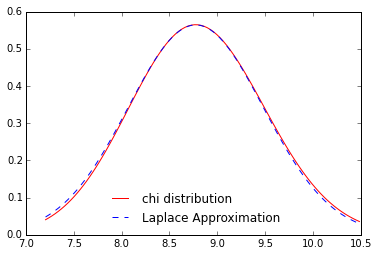

In [101]:
# Laplace approximation for the chi distribution. loc is the mean and scale the std of gaussian distribution in scipy
k = 78
x = np.linspace(st.chi.ppf(0.01, k), st.chi.ppf(0.99, k), 100)
plt.plot(x, st.chi.pdf(x, k),'r-', label='chi distribution')
plt.plot(x, st.norm.pdf(x, loc=np.sqrt(k - 1), scale=np.sqrt(0.5) ),'b--', label='Laplace Approximation')
plt.legend(loc='best', frameon=False)

### Bayesian Logistic Regression - Parameter distribution

Following the bayesian framework we need to define a probability density over the learnable parameters $W$. Therefore, let's define the prior $p(W)$ a gaussian and the likelihood $p(T|W)$ of the data as the cross entropy. Then we need to use the bayes theorem to compute the posteriori distribution $p(W|T)$.
$$P(w|t) \approx P(t|w)P(w)$$
$$ln~P(w|t) \approx \mathcal{N}(m_0,S_0) + \sum_n t_{n}ln(y_n) + (1-t_n)(1-y_{nk}) $$
where $m_0$ and $S_0$ are hyperparameters of the prior. $y_n = sigmoid(w^t x_n)$

Thus, we can use the laplace approximation to find the gaussian $q(w)= \mathcal{N}(W_{map},S_n)$ that approximates $ln~P(w|t)$. More specifically, we can use the IRLS algorithm to obtain the maximum a posteriori (MAP) $W_{map}$ and compute the hessian to find the parameter $S_n$ of the distribution q(w).

In order to find the W_{map} parameter with the IRLS algorithm we need the gradient and hessian, that are defined as follow:

$$- \nabla ln~p(w|t) = \Phi^T (y − t) + S_0^{−1}w − S_0 m_0$$
$$ H = S_0^{-1} + \Phi^T R \Phi = S_N^{-1}$$
$$ R_{nn} = y_n(1-y_n)$$


In [102]:
#compute the parameter distribution
#parameters for the IRLS algorithm and prior's hyperparameters
MAX_IT = 100; M_0 = np.zeros((V+1,1)); S_0 = 0.8*np.identity(V+1);

# Adapt dataset for basis functions (here just use phi(X) = X)
X_tr_lr = np.concatenate((np.ones((N_tr,1)), X_tr), axis=1)

# IRLS Algorithm to find W_map
W_lr = np.zeros((V+1,C)); S_n = [];
for cl in range(C):
    for it in range(MAX_IT):
        #prediction
        Y = np.dot(X_tr_lr, W_lr[:,[cl]]);Y = 1 / (1 + np.exp(-Y))        
        Tg = np.equal(T_tr, cl).reshape(N_tr,1)
                
        #compute gradient
        G = np.sum(X_tr_lr * (Y - Tg), axis = 0, keepdims=True).T + np.dot(np.linalg.pinv(S_0), W_lr[:,[cl]]) - np.dot(S_0,M_0);
        
        #compute hessian
        R = np.identity(N_tr) * (Y *(1-Y))
        H = np.linalg.pinv(S_0) + np.dot(np.dot(X_tr_lr.T, R),X_tr_lr)
        
        #update weights        
        W_lr[:,[cl]] = W_lr[:,[cl]] - np.dot(np.linalg.pinv(H), G)
            
        #compute Sn for Wmap    
        if (it == MAX_IT-1):
            Y = np.dot(X_tr_lr, W_lr[:,[cl]]);Y = 1 / (1 + np.exp(-Y))
            Tg = np.equal(T_tr, cl).reshape(N_tr,1)
            R = np.identity(N_tr) * (Y *(1-Y))
            H = np.linalg.pinv(S_0) + np.dot(np.dot(X_tr_lr.T, R),X_tr_lr)            
            S_n.append(H)
            

pred_w = lambda w, cl: st.multivariate_normal.pdf(w, mean=W_lr[:,cl], cov=S_n[cl]) 


### Bayesian Logistic Regression - Predictive Distribution

Our obejctive is to predict the probability of a new sample to belong to a certain class. In order to achieve our goal we need to compute the parameters of the predictive distribution for the Bayesian Logistic Regression. The predictive distribution for class $C_1$ , given a new feature vector $\phi(x)$, is obtained by marginalizing the posterior distribution $p(w|t)$, which is approximated by a Gaussian distribution q(w) (showed before),

$$p(C_1 \mid \phi,t) = \int p(C_1 \mid \phi, w) p(w \mid t) \approx \int \sigma(w^T\phi) q(w) dw$$

and the corresponding probability for class $C_2$ is given by $p(C_2 \mid \phi,t) = 1 - p(C_1 \mid \phi,t)$ where $\sigma(.)$ is the sigmoid function. We can rewrite the equation above, using $\sigma(w^T\phi) = \int \delta(a - w^T\phi) \sigma(a) da$. Therefore,

$$\int \sigma(w^T\phi) q(w) dw = \int\int \delta(a - w^T\phi) \sigma(a) q(w) da dw = \int \sigma(a) p(a) da$$

where $p(a) = \int \delta(a - w^T\phi) q(w) dw$. The function $\delta(a - w^T\phi)$ can be approximated by a gaussian $\mathcal{N}(w^T,\alpha I)$ where $\alpha$ tends to infinity. Thus,

$$p(C_1 |t) = \int \sigma(a) p(a) da = \int \sigma(a) \mathcal{N} (a|\mu_a , \sigma_a^2 ) da$$

where $\mu_a = w^T\phi$ and $\sigma_a^2 = \phi^T S_N \phi$ from the Bayesian Theorem for Linear Gaussian.

The integration is difficult due to the logistic function $\sigma(·)$. Instead, we can use the inverse probit function $\Phi(a) = \int_{-\inf}^{a} \mathcal{N}(\theta|0, 1)d\theta$ to approximate the sigmoid function. The advantage of using an inverse probit function is that the convolution with a Gaussian can be expressed analytically. Therefore, the approximate predictive distribution is,

$$p(C_1 |t) = \int \Phi(a) \mathcal{N} (a|\mu_a , \sigma_a^2 ) da = \sigma(\mathcal{K}(\sigma_a^2) \mu_a)$$

where:
$$\mu_a = w_{map}^T\Phi$$
$$\sigma_a^2 = \Phi^T S_N \Phi$$
$$\mathcal{K}(\sigma^2) = (1 + \pi\sigma^2/8)^{-\frac{1}{2}}$$

These model is designed to the binary classification problem, but can be extended to the multiclass case using the same approached used in the traditional logistic regression, the one-vs-all algorithm.

Training set accuracy: 0.95
Test set accuracy: 0.96


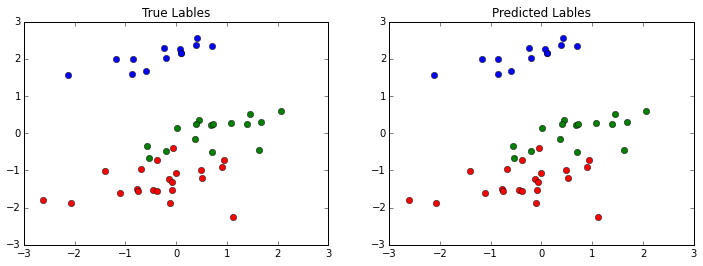

In [103]:
#Predictive Distribution
sigmoid = lambda x: 1 / (1 + np.exp(-x))
BLR_prob = lambda x, cl: sigmoid(np.power(1 + ((np.pi * np.dot(W_lr[:,[cl]].T, np.dot(S_n[cl], W_lr[:,[cl]])))/8),-0.5) *  np.dot(np.concatenate((np.ones(1),x.T)), W_lr[:,[cl]]))
BLR_pred = lambda x: np.argmax(np.array([BLR_prob(x,0), BLR_prob(x,1), BLR_prob(x,2)]).flatten())

#Evaluate
Y_BLR_pred_tr = np.apply_along_axis(BLR_pred,1,X_tr)
Y_BLR_pred_te = np.apply_along_axis(BLR_pred,1,X_te)

print('Training set accuracy: {}'.format(acc(Y_BLR_pred_tr,T_tr)))
print('Test set accuracy: {}'.format(acc(Y_BLR_pred_te,T_te)))
plt.figure(figsize=(12,4))
plt.subplot(1,2,1);plot_cls_decision(X_te, T_te);plt.title('True Lables')
plt.subplot(1,2,2);plot_cls_decision(X_te, Y_LR_pred_te);plt.title('Predicted Lables')